# Time Series mini Project: Predict Temperature

*The project assignment was created by 2022 Pragmatic Institute, but fulfilled by Hanyu Yangcheng.*

Time series prediction presents its own challenges which are different from machine-learning problems. In this project, we will start with building simple models (i.e. temperature prediction based on a set of indicator variables), and then develop slighly complex model (i.e. Fourier model to deal with seasonal features).


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## The data

The weather data of 5 US. cities were provided by Pragmatic Institute and not shared here.  Let's take a look of the data first.

In [ ]:
df = pd.read_csv('train.v2.csv.gz')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392136 entries, 0 to 392135
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   station         392136 non-null  object
 1   time            392136 non-null  object
 2   temp            392136 non-null  object
 3   dew_point       392136 non-null  object
 4   pressure        392136 non-null  object
 5   wind_speed      392136 non-null  object
 6   wind_direction  392136 non-null  object
 7   precip_hour     392136 non-null  object
 8   weather_codes   392136 non-null  object
dtypes: object(9)
memory usage: 26.9+ MB


The `station` column indicates the city.  The `time` is measured in UTC.  Both `temp` and `dew_point` are measured in degrees Fahrenheit.  The `wind_speed` is in knots, and the `precip_hour` measures the hourly precipitation in inches.

First step is to remove rows without valid temperature measurements. In this dataset, missing values are indicated by a flag value `M`.

In [5]:
df = df[df['temp'] != 'M']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392020 entries, 0 to 392135
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   station         392020 non-null  object
 1   time            392020 non-null  object
 2   temp            392020 non-null  object
 3   dew_point       392020 non-null  object
 4   pressure        392020 non-null  object
 5   wind_speed      392020 non-null  object
 6   wind_direction  392020 non-null  object
 7   precip_hour     392020 non-null  object
 8   weather_codes   392020 non-null  object
dtypes: object(9)
memory usage: 29.9+ MB


## Develop a simple model for one city

Seasonal features are relatively safe to extrapolate into the future. There are two ways to handle seasonality. The simplest (and perhaps most robust) is to have a set of indicator variables. That is, make the assumption that the temperature at any given time is a function of only the month of the year and the hour of the day, and use that to predict the temperature value.

Although there are multiple cities in the dataset, we want to make it simple and build a model to predict the temperature for a given hour in a given month only for New York City.

In [7]:
df_nyc = df[df['station'] == 'NYC']

In [12]:
df_nyc['time'][:10]

314317    2010-01-01 00:51
314318    2010-01-01 01:51
314319    2010-01-01 02:51
314320    2010-01-01 03:51
314321    2010-01-01 04:51
314322    2010-01-01 05:51
314323    2010-01-01 06:51
314324    2010-01-01 07:51
314325    2010-01-01 08:51
314326    2010-01-01 09:51
Name: time, dtype: object

The `time` column is `string` data type. We need to build a `Transformer` to extract `month` and `hour` from the data.

In [9]:
from sklearn import base
import datetime as dt

class TimeTransformer(base.BaseEstimator, base.TransformerMixin):
    """Extract 'month' and 'hour' from 'time' column"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        out = pd.DataFrame()
        out['month'] = pd.DatetimeIndex(pd.to_datetime(X['time'])).month
        out['hour'] = pd.DatetimeIndex(pd.to_datetime(X['time'])).hour
        return out

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder  # use OneHotEncoder to encode 'month' and 'hour'

nyc_model = Pipeline([('time_encoder', TimeTransformer()),
                      ('ohe', OneHotEncoder()),
                      ('regressor', LinearRegression())
                     ])
nyc_model.fit(df_nyc, df_nyc['temp'].astype('float64'))

Pipeline(steps=[('time_encoder', TimeTransformer()), ('ohe', OneHotEncoder()),
                ('regressor', LinearRegression())])

In [11]:
nyc_model.score(df_nyc, df_nyc['temp'].astype('float64'))

0.7767776751865024

## Scale up to handle all the cities

Now we want to extend this same model to handle all of the cities in the dataset. Rather than adding features to the existing model, we'll just make a new copy of the model for each city.

The model developed above is a particular instance of a Pipeline. We can make a **factory function** that returns a new copy of that Pipeline each time it's called.

In [13]:
def season_factory():
    city_pipe = Pipeline([('time_encoder', TimeTransformer()),
                      ('ohe', OneHotEncoder()),
                      ('regressor', LinearRegression())
    ])
    return city_pipe # A single estimator or a pipeline

While we could manually call this function for each city in our dataset, we can build a "group-by" estimator to avoid the repetitive process. This estimator takes a column name and a factory function as an argument.  The `fit` method will group the incoming data by that column, and for each group it will call the factory to create a new instance to be trained by on that group. Then, the `predict` method will look up the corresponding model for each row and perform a predict using that model.

In [16]:
import numpy as np

class GroupbyEstimator(base.BaseEstimator, base.RegressorMixin):
    
    def __init__(self, column, estimator_factory):
        # column is the value to group by; estimator_factory can be called to produce estimators
        self.column = column
        self.estimator_factory = estimator_factory
    
    def fit(self, X, y):
        # Create an estimator and fit it with the portion in each group
        self.estimators = dict() #create an empty dict for estimators to be created
        for loc in X[self.column].unique():
            self.estimators[loc] = self.estimator_factory()
            ind = (X[self.column] == loc)
            self.estimators[loc].fit(X[ind], y[ind])
        return self

    def predict(self, X):
        # Call the appropriate predict method for each row of X
        output = pd.Series(index = X.index, dtype = "float64") # create an empty numpy array with the same indices of the X
        for loc in X[self.column].unique():
            index = X[X[self.column] == loc].index
            y_loc = self.estimators[loc].predict(X.loc[index])
            output.update(pd.Series(y_loc, index = index))
        return output

Now, we should be able to build an equivalent model for each city:

In [17]:
all_cities_model = GroupbyEstimator('station', season_factory).fit(df, df['temp'])

In [18]:
 # Scaled up the model to handle multiple cities and reached a significantly better prediction coefficient
all_cities_model.score(df, df['temp'])

0.87044402473022

## Fourier model

Now we can explore another way to deal with the seasonality.  Since we know that temperature is roughly sinusoidal, we know that a reasonable model might be

$$ y_t = y_0 \sin\left(2\pi\frac{t - t_0}{T}\right) + \epsilon $$

where $y_0$ and $t_0$ are parameters to be learned and $T$ is the period - one year for seasonal variation, one day for daily, etc.  While this is linear in $y_0$, it is not linear in $t_0$. However, we know from Fourier analysis, that the above is
equivalent to

$$ y_t = A \sin\left(2\pi\frac{t}{T}\right) + B \cos\left(2\pi\frac{t}{T}\right) + \epsilon $$

which is linear in $A$ and $B$.

We are going to create a model containing sinusoidal terms on one or more time scales, and fit it to the data using a linear regression.

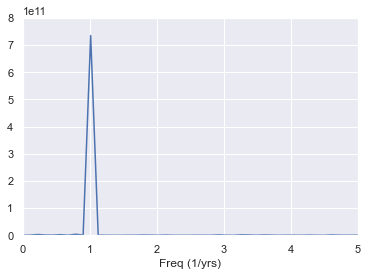

In [21]:
from math import pi

fft_temp = np.fft.fft(df_nyc['temp'].astype('float64').values - df_nyc['temp'].astype('float64').values.mean())
yrs = (pd.to_datetime(df_nyc['time']).index[-1] - pd.to_datetime(df_nyc['time']).index[0]) / (365.*24)

plt.plot(np.arange(len(fft_temp)) / yrs, np.abs(fft_temp)**2)
plt.axis([0, 5, 0, 8e11])
plt.xlabel('Freq (1/yrs)');

It's obveious and reasonable that there is seasonality at a frequency of once a year. Now let's determine the seasonality for each day.

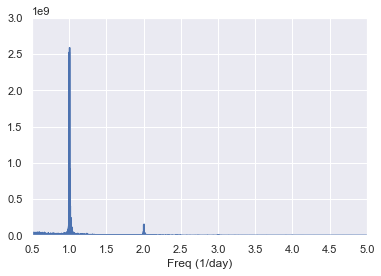

In [22]:
yrs = (pd.to_datetime(df_nyc['time']).index[-1] - pd.to_datetime(df_nyc['time']).index[0]) / 24.

plt.plot(np.arange(len(fft_temp)) / yrs, np.abs(fft_temp)**2)
plt.axis([0.5, 5, 0, 3e9])
plt.xlabel('Freq (1/day)');

Now we build a **Fourier Transformer** and build a model that combines daily and annual seasonal features.

In [23]:
from math import pi
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer

class TimeConverter(base.BaseEstimator, base.TransformerMixin):
    # Convert 'time' column from 'string' to 'datetime' type    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X['time'] = X['time'].apply(pd.to_datetime)
        return X


class FourierTransformer(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, freq):
        self.freq = freq
        
    def fit(self, X, y=None):
        self.X0 = X['time'].loc[X.index[0]]
        return self
    
    def transform(self, X):
        dt = (X['time'] - self.X0).dt.days * 2 * np.pi * self.freq
        return np.c_[np.sin(dt), np.cos(dt)]
    
FourierUnion = FeatureUnion([('fourier_annual', FourierTransformer(1/365)),
                             ('fourier_daily', FourierTransformer(1))])

In [24]:
def fourier_factory():
    fourier_pipe = Pipeline([('datetime', TimeConverter()),
                             ('fourier_components', FourierUnion),
                             ('regressor', LinearRegression())])
    return fourier_pipe

In [25]:
fourier_model = GroupbyEstimator('station', fourier_factory).fit(df, df['temp'])

In [26]:
fourier_model.score(df, df['temp'])

0.8245426614794784